##Installing and loading libraries

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 22 06:29:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pydicom
#!pip install mlflow

     |████████████████████████████████| 2.0 MB 29.3 MB/s 


In [3]:
#below is to prevent keras segmentation models 'str' object has no attribute 'decode' error with segmentation models
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 30.1 MB/s 
     |████████████████████████████████| 15.7 MB 1.3 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

In [4]:
#tensorboard dev
import tensorflow as tf
import datetime
from tensorboard.plugins.hparams import api as hp

In [5]:
import numpy as np
import glob2
import pandas as pd
from sklearn.model_selection import train_test_split
import os, shutil
import tensorflow as tf
import pydicom
import glob2
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import tqdm
import itertools
#import mlflow
import numpy as np
import keras
import pandas as pd
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import *
from keras_preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2

##Retrieving Data

In [6]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# copying patient data into the session
!cp /content/gdrive/MyDrive/Donnes_patients/new_less_empty_2.zip /content/
!unzip -q /content/new_less_empty_2.zip 

## Data Generator

In [ ]:
import tensorflow
#libraries for augmentation
from skimage.util import random_noise
from PIL import Image
import numpy as np
from imgaug import augmenters as iaa
import random

In [ ]:
class DataGenerator(tensorflow.keras.utils.Sequence):
  def __init__(self, df, modality="train", batch_size=1, dim=(500,500), n_channels=3, n_classes=3, shuffle=True, rgb=True, post_treatment=True):

    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.rgb = rgb
    self.post_treatment = post_treatment

    # in case the image paths are different , you might have to modify them
    #self.dataframe["mask_path"] = self.dataframe["mask_path"].apply(lambda x:x.replace(OLD_HOME,NEW_HOME))

    # in case the mask paths are different , you might have to modify them                                                                                             
    #self.dataframe["im_path"] = self.dataframe["im_path"].apply(lambda x:x.replace(OLD_HOME,NEW_HOME))
                                                                                                      
    # get data in and shuffle
    self.dataframe = df.reset_index(drop=True).sample(frac=1)
        
    # get the ID list
    self.list_IDs = list(self.dataframe.index)
        
        # depending on the models u must specify a given number of channels (3 or 1)
    self.n_channels = n_channels
        
    # n classes (binary problem or categorical problem 
    # you can use this parameter for to_categorical for ex)

    self.n_classes = n_classes
    self.shuffle = shuffle

    # simple conversion dictionary
    self.map = {"patho":1,"non_patho":0}
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))
  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    self.list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(self.list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  #draw image on mask at the end of each epoch for example
  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' 
    # X : (n_samples, *dim, n_channels)
    # y : (n_samples, *dim, n_channels)

    # Initialization

    # images
    if self.rgb:

      X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float16)

    else:
      X = np.empty((self.batch_size, *self.dim, 1), dtype=np.float16)

    # masks
    y = np.empty((self.batch_size, *self.dim, 1))

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
            
        # Store sample
        # you might want to convert the data to np.uint8 if needed
        # can try to train on raw data as well
        im = np.load(self.dataframe.loc[ID,"image_path"]) # we can resize the image at this step
        im = cv2.resize(im, dsize=(500, 500))
        im = im.astype(np.uint8)
        
        # data augmentation (add noise, etc.) TO DO add random transformations
        my_random = random.randint(1,10)
        if my_random > 5:
          aug = iaa.AdditiveGaussianNoise(loc=0, scale=0.1*255) #Gausian noise
          im = aug.augment_image(im)
        # salt and pepper noise
        aug = iaa.SaltAndPepper(p=0.05)
        im = aug.augment_image(im)

        # Store mask:
        # the mask values must be between 0 and 1
        mask = np.load(self.dataframe.loc[ID,"mask_path"]) /255.  #we can resize the image at this step
        mask = cv2.resize(mask, dsize=(500, 500))
        #image of mask is /255 (resizing should be before this division)    
        if self.post_treatment:

          im = im.astype(np.uint8)

        if self.rgb:

          X[i,] = cv2.merge([im, im, im]) # convert the image (numpy array in to rgb)
                                          #gives a dimension (shape) of (512,512,3)
        else: 
          X[i,] = np.expand_dims(im, axis=-1)

        # Store class
        y[i] = np.expand_dims(mask, axis=-1)     #to_categorical(mask, num_classes=self.n_classes) 
                    # depending on your loss function 
                    # (you might have to convert it to a 
                    # mask of size 512x 512x nclasses like below)

    return X, y

## Forming train, validation and test datasets

In [ ]:
#training dataset
train_data = glob2.glob('/content/content/less_empties/train_new/*/*.npy')
train_images = [file for file in train_data if 'mask' not in file]
train_masks = [file for file in train_data if 'mask' in file]
# validation set
val_data = glob2.glob('/content/content/less_empties/val_new/*/*.npy')
val_images = [file for file in val_data if 'mask' not in file]
val_masks = [file for file in val_data if 'mask' in file]
#test dataset
test_data = glob2.glob('/content/content/less_empties/test_new/*/*.npy')
test_images = [file for file in test_data if 'mask' not in file]
test_masks = [file for file in test_data if 'mask' in file]

print(f'There are {len(train_images)} training images and {len(train_masks)} training masks.')
print(f'There are {len(val_images)} validation images and {len(val_masks)} validation masks.')
print(f'There are {len(test_images)} testing images and {len(test_masks)} testing masks.')

In [ ]:
# sorting the image and mask list
sorted_train_images = sorted(train_images, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.npy')[0]))
sorted_train_masks = sorted(train_masks, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.npy')[0]))
sorted_val_images = sorted(val_images, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.npy')[0]))
sorted_val_masks = sorted(val_masks, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.npy')[0]))
sorted_test_images = sorted(test_images, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.npy')[0]))
sorted_test_masks = sorted(test_masks, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.npy')[0]))

#forming a dataframe with sorted image and mask lists
train_df = pd.DataFrame(list(zip(sorted_train_images, sorted_train_masks)), columns = ['image_path', 'mask_path'])
val_df = pd.DataFrame(list(zip(sorted_val_images, sorted_val_masks)), columns = ['image_path', 'mask_path'])
test_df = pd.DataFrame(list(zip(sorted_test_images, sorted_test_masks)), columns = ['image_path', 'mask_path'])

#saving the dataframes as .csv files
train_csv = train_df.to_csv('train.csv', index=None)
val_csv = val_df.to_csv('val.csv', index=None)
test_csv = test_df.to_csv('test.csv', index=None)

#verify that the train masks and images correspond to each other
train_set = pd.read_csv('train.csv')
train_set.head()

In [ ]:
# inflating th training set in order to have more images for the data augmentation
train_set = pd.concat([train_set]*2, axis=0)
train_set = train_set.sample(frac=1)
print(train_set.shape)

In [ ]:
#verify that the validation masks and images correspond to each other
val_set = pd.read_csv('val.csv')
val_set.head()

In [ ]:
#verify that the test masks and images correspond to each other
test_set = pd.read_csv('test.csv')
test_set.head()

In [ ]:
#creating the data generators
train_generator = DataGenerator(train_set)
val_generator = DataGenerator(val_set)
test_generator = DataGenerator(test_set)

## Verifing the images

In [ ]:
# below is a fix for the error: Cannot import name '_png' from 'matplotlib'
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

In [ ]:
val_image = val_generator[1][0][0]
#val_image2 = np.squeeze(val_image, axis=-1)
plt.imshow((val_image).astype(np.uint8))
plt.title('example validation dataloader')
plt.show() #TO DO add title to this image

In [ ]:
train_image = train_generator[1][0][0]
plt.imshow((train_image).astype(np.uint8))
plt.title('example training dataloader')
plt.show() #TO DO add title to this image

##Training

In [ ]:
from keras.callbacks import *
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation, Dense

In [ ]:
#installing Keras segmentation mdoels to use their loss functions
!pip3 install -U segmentation-models

In [ ]:
import tensorflow.keras.backend as K
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

In [ ]:
# chosse a fancy model name
model_name = 'test9.h5'
root = os.getcwd()
placement = os.path.join(root,model_name) #path for the callbacks to save weights, etc.

In [ ]:
placement

In [ ]:
# tensorboard dev callbacks
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 512,
    'dropout': 0.2
})

callbacks = [
    keras.callbacks.ModelCheckpoint(placement, 
                                    save_weights_only=True, 
                                    save_best_only=True, 
                                    mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tensorboard_callback, hparams_callback
]

In [ ]:
BACKBONE = 'resnet101'
BATCH_SIZE = 32
CLASSES = ['LN']
LR = 0.0001
EPOCHS = 40
input_shape = (500,500,3)
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# using vgg16 pretrained model
from keras.applications import vgg16
from keras.models import Model,load_model
VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
print('Model loaded.')

In [ ]:
output_ = VGG16.output
output_

In [ ]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
vgg_model.summary()

## Forming a Unet-stype top for the pre-trained vgg model

In [ ]:
def ModelEnhancer():
    input_shape = (500, 500, 3)
    VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    last_layer = VGG16.output
    
    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = False
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False
            
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)    
    
    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    '''model_ = Conv2D(32,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)'''
    
    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Model(VGG16.input,model_)
    
    return model_

In [ ]:
Model_ = ModelEnhancer()
Model_.summary()

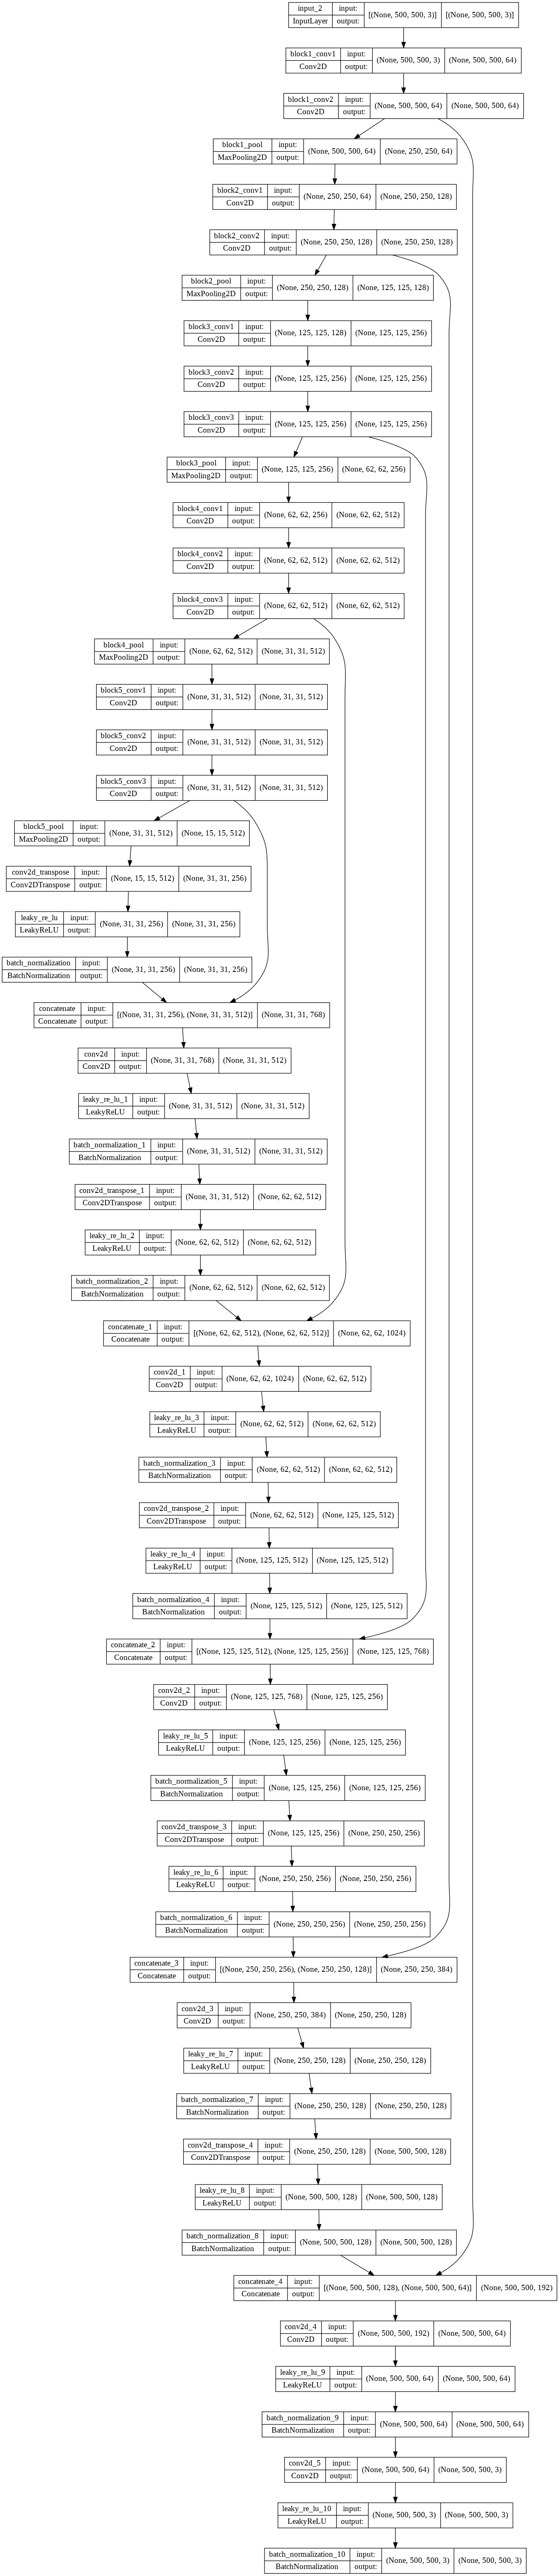

In [ ]:
# saving the model architecture as png image
from keras.utils.vis_utils import plot_model
plot_model(Model_,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

### Defining network parameters and the loss function

Some loss functions are taken from [this site](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html).

In [ ]:
def tversky_loss(beta):
  def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = y_true * y_pred
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

    return 1 - tf.reduce_sum(numerator) / tf.reduce_sum(denominator)

  return loss 

In [ ]:
# To decrease the number of false negatives, set β>1. To decrease the number of false positives, set β<1. 
def weighted_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = 1 - tf.cast(y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 
    return tf.reduce_mean(o)

  return loss

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
# define optimizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
'''
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
'''

## LOSS FUNCTIONS TO TRY

total_loss = sm.losses.JaccardLoss()

#total_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=2.0)

#total_loss = sm.losses.CategoricalCELoss()

#total_loss = sm.losses.DiceLoss(beta=1, class_weights=None, class_indexes=None, per_image=False, smooth=1e-05)

#total_loss = weighted_cross_entropy(beta=0.8)

#total_loss = tversky_loss(beta=0.5)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
#Compiling the model with the loss function and the metrics chosen above
Model_.compile(optimizer = optim, loss = total_loss, metrics = metrics)

#Model_.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [ ]:
checkpointer = ModelCheckpoint(model_name, verbose=1, mode='auto', monitor='loss',save_best_only=True)

In [ ]:
steps_per_epoch = len(train_generator)//BATCH_SIZE
validation_steps = len(val_generator)//BATCH_SIZE

In [ ]:
#mlflow.keras.autolog()

history = Model_.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=EPOCHS, 
    callbacks=callbacks, #tensorboard dev callbacks 
    validation_data=val_generator, 
    validation_steps=validation_steps,
)

In [ ]:
print(history.history.keys())

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['f1-score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model Evaluation

In [ ]:
test_dataloader = DataGenerator(test_set, batch_size=32, shuffle=False)
# load best weights
Model_.load_weights(placement) 
#scores = Model_.evaluate_generator(test_dataloader)

Predicting testing images:

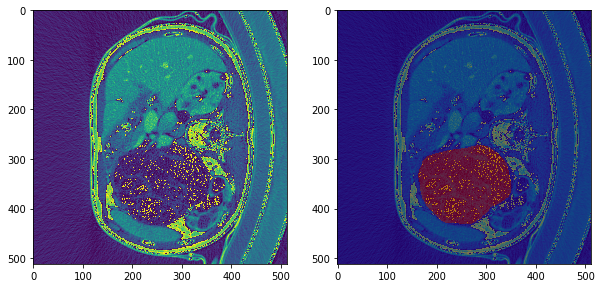

In [ ]:
# the actual image
im = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/image_67.npy')
im = im.astype(np.uint8)
immask = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/ID9_composite_mask_67.npy')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, interpolation='none')
plt.imshow(immask, 'jet', interpolation='none', alpha=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


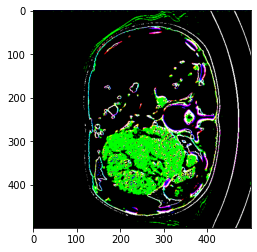

In [ ]:
#image to predict need to have same dimensions as the model
testing_image = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/image_67.npy')
testing_image = cv2.resize(testing_image, dsize=(500, 500))
testing_image = cv2.merge([testing_image,testing_image,testing_image])
new_testing_image = np.expand_dims(testing_image, axis=0)
prediction = Model_.predict(new_testing_image)
a = np.squeeze(prediction, axis=0)
b = np.multiply(testing_image, a)
plt.imshow(b)
plt.show()

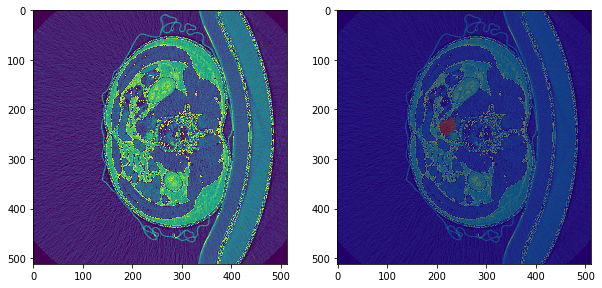

In [ ]:
# the actual image
im = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID6/image_280.npy')
im = im.astype(np.uint8)
immask = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID6/ID6_composite_mask_280.npy')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, interpolation='none')
plt.imshow(immask, 'jet', interpolation='none', alpha=0.5)
plt.show()

In [ ]:
testing_image2 = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID6/image_280.npy')
testing_image2 = cv2.resize(testing_image2, dsize=(500, 500))
testing_image2 = cv2.merge([testing_image2,testing_image2,testing_image2])
new_testing_image2 = np.expand_dims(testing_image2, axis=0)
prediction2 = Model_.predict(new_testing_image2)
a2 = np.squeeze(prediction2, axis=0)
#b2 = np.multiply(testing_image2, a2)
plt.imshow(a2)
plt.show()

Predicting a training image (this should always be successful):

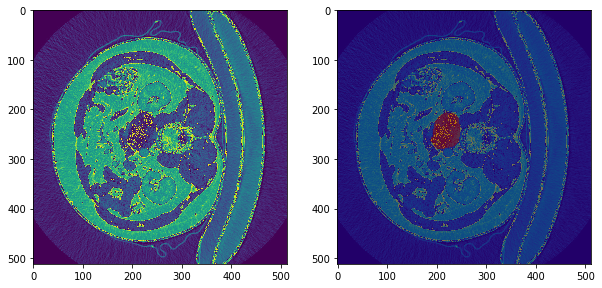

In [ ]:
# the actual image
im = np.load('/content/content/less_empties/train_new/ID2/image_512.npy')
im = im.astype(np.uint8)
immask = np.load('/content/content/less_empties/train_new/ID2/ID2_composite_mask_512.npy')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, interpolation='none')
plt.imshow(immask, 'jet', interpolation='none', alpha=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


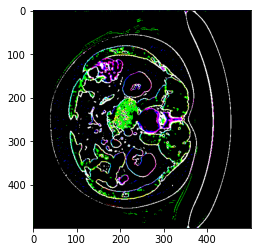

In [ ]:
# the prediction
train_image = np.load('/content/content/less_empties/train_new/ID2/image_512.npy')
train_image = cv2.resize(train_image, dsize=(500, 500))
train_image = cv2.merge([train_image,train_image,train_image])
new_train_image = np.expand_dims(train_image, axis=0)
prediction3 = Model_.predict(new_train_image)
a3 = np.squeeze(prediction3, axis=0)
b3 = np.multiply(train_image, a3)
plt.imshow(b3)
plt.show()

In [ ]:
#downloading the model
#from google.colab import files
#files.download(placement)

## Uploading the experiment on Tensorboard dev

In [ ]:
#This will require access authorization

!tensorboard dev upload --logdir ./logs \
  --name f'vgg segmentation {model_name}' \
  --description "Training results from https://colab.research.google.com/drive/1tHc_Lnr255zw_zshtPWuHkLWu446qMZw?usp=sharing" \
  --one_shot



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=C77sasrHmFQiuu5WhPy8Y4ygbuzbDE&prompt=consent&access_type=offline
Enter 

Each individual upload has a unique experiment ID. This means that if you start a new upload with the same directory, you will get a new experiment ID. You can view all your uploaded experiments at https://tensorboard.dev/experiments/. Alternatively, you can list your experiments in the terminal using the following command:
```
tensorboard dev list
```

#Classify pathological & non pathological

In [ ]:
targets = glob2.glob('/content/content/less_empties/*/*/*')
target_files = [file for file in targets if 'mask' not in file]

In [ ]:
target_files

In [ ]:

for image in target_files:
  try:  
    filename = f'{image.strip(".npy")}.png'
    original_image = np.load(image)
    cv2.imwrite(filename, original_image)
  except:
    pass

In [ ]:
!rm /content/content/less_empties/*/*/*.npy

In [ ]:
!cp /content/content/less_empties/test_new/NIFTI_PATIENT_ID9/image_67.png /content

In [ ]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

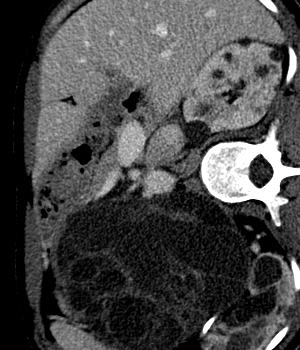

In [ ]:
from PIL import Image
im = Image.open('/content/image_67.png')
crop_center(im, 300, 350)

In [ ]:
def center_cropper(path, crop_width, crop_height):
  im = Image.open(path)
  new_im = crop_center(im, crop_width, crop_height)
  new_im.save(path, 'PNG')

In [ ]:
#training dataset
train_data = glob2.glob('/content/content/less_empties/train_new/*/*.png')
train_images = [file for file in train_data if 'mask' not in file]

# validation set
val_data = glob2.glob('/content/content/less_empties/val_new/*/*.png')
val_images = [file for file in val_data if 'mask' not in file]

#test dataset
test_data = glob2.glob('/content/content/less_empties/test_new/*/*.png')
test_images = [file for file in test_data if 'mask' not in file]

print(f'There are {len(train_images)} training images.')
print(f'There are {len(val_images)} validation images.')
print(f'There are {len(test_images)} testing images.')

There are 3375 training images.
There are 891 validation images.
There are 733 testing images.


In [ ]:
# sorting the image and mask list
sorted_train_images = sorted(train_images, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.png')[0]))
sorted_val_images = sorted(val_images, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.png')[0]))
sorted_test_images = sorted(test_images, key=lambda x:str(x.split('/')[-1].split('_')[-1].split('.png')[0]))

#forming a dataframe with sorted image and mask lists
train_df = pd.DataFrame(list(sorted_train_images), columns = ['image_path'])
val_df = pd.DataFrame(list(sorted_val_images), columns = ['image_path'])
test_df = pd.DataFrame(list(sorted_test_images), columns = ['image_path'])


In [ ]:
#saving the dataframes as .csv files
train_csv = train_df.to_csv('train.csv', index=None)
val_csv = val_df.to_csv('val.csv', index=None)
test_csv = test_df.to_csv('test.csv', index=None)

#verify that the train masks and images correspond to each other
train_set = pd.read_csv('train.csv')
train_set.head()

,image_path
0,/content/content/less_empties/train_new/ID69/i...
1,/content/content/less_empties/train_new/ID36/i...
2,/content/content/less_empties/train_new/ID16/i...
3,/content/content/less_empties/train_new/ID69/i...
4,/content/content/less_empties/train_new/ID36/i...


In [ ]:
# TO DO: Add pathology information to dataset (0 non-patho, 1 patho)

##Data augmentation


In [ ]:
# SOURCE: https://www.kaggle.com/babbler/mnist-data-augmentation-with-elastic-distortion
# https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates


def elastic_transform(image, alpha_range, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       
   # Arguments
       image: Numpy array with shape (height, width, channels). 
       alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
           Controls intensity of deformation.
       sigma: Float, sigma of gaussian filter that smooths the displacement fields.
       random_state: `numpy.random.RandomState` object for generating displacement fields.
    """
    
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))
    
    transformed_images = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

    return transformed_images

### Visualizing the tuning

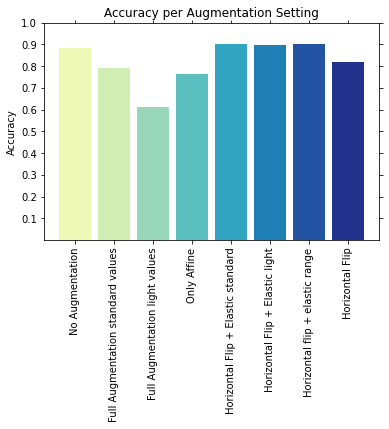

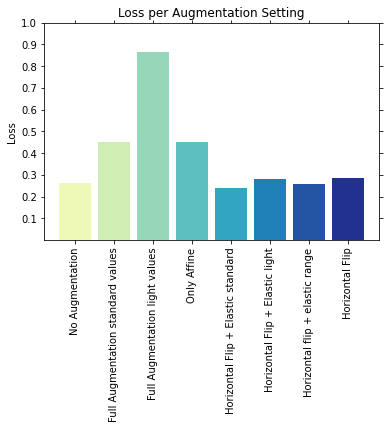

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Accuracies: ###########################
height = [0.8830, 0.7917, 0.6132, 0.7631, 0.9005, 0.8957, 0.9008, 0.8193]
bars = ('No Augmentation', 'Full Augmentation standard values', 'Full Augmentation light values', 'Only Affine',
        'Horizontal Flip + Elastic standard', 'Horizontal Flip + Elastic light', 'Horizontal flip + elastic range',
        'Horizontal Flip'
       )

x_pos = np.arange(len(bars))

colours = sns.color_palette("YlGnBu", 8)

# Create bars and choose color
plt.bar(x_pos, height, color = colours)
 
# Add title and axis names
plt.title('Accuracy per Augmentation Setting')
plt.ylabel('Accuracy')

# Create names on the x axis
plt.yticks((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.xticks(x_pos, bars, rotation = 90)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')

# Show graph
plt.show()

# Losses #########################
# Accuracies:
height = [0.2641, 0.4504, 0.8652, 0.4492, 0.2381, 0.2797, 0.2563, 0.2848]
bars = ('No Augmentation', 'Full Augmentation standard values', 'Full Augmentation light values', 'Only Affine',
        'Horizontal Flip + Elastic standard', 'Horizontal Flip + Elastic light', 'Horizontal flip + elastic range',
        'Horizontal Flip'
       )

colours = sns.color_palette("YlGnBu", 8)

# Create bars and choose color
plt.bar(x_pos, height, color = colours)
 
# Add title and axis names
plt.title('Loss per Augmentation Setting')
plt.ylabel('Loss')

# Create names on the x axis
plt.yticks((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.xticks(x_pos, bars, rotation = 90)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')

# Show graph
plt.show()

In [ ]:
#creating train/val/test dataframes with Tumor information
# 1: pathological
# 0: not pathological 
class_train_set = pd.read_csv('trainClassification2.csv')
class_val_set = pd.read_csv('valClassification2.csv')
class_test_set = pd.read_csv('testClassification2.csv')

In [ ]:
class_train_set

,image_path,Tumor
0,/content/content/less_empties/train_new/ID11/i...,1
1,/content/content/less_empties/train_new/ID11/i...,1
2,/content/content/less_empties/train_new/ID11/i...,1
3,/content/content/less_empties/train_new/ID11/i...,1
4,/content/content/less_empties/train_new/ID11/i...,1
...,...,...
3370,/content/content/less_empties/train_new/ID84/i...,1
3371,/content/content/less_empties/train_new/ID84/i...,1
3372,/content/content/less_empties/train_new/ID84/i...,1
3373,/content/content/less_empties/train_new/ID84/i...,1


In [ ]:
class_val_set

,image_path,Tumor
0,/content/content/less_empties/val_new/ID17/ima...,1
1,/content/content/less_empties/val_new/ID17/ima...,1
2,/content/content/less_empties/val_new/ID17/ima...,1
3,/content/content/less_empties/val_new/ID17/ima...,1
4,/content/content/less_empties/val_new/ID17/ima...,1
...,...,...
886,/content/content/less_empties/val_new/ID85/ima...,0
887,/content/content/less_empties/val_new/ID85/ima...,0
888,/content/content/less_empties/val_new/ID85/ima...,0
889,/content/content/less_empties/val_new/ID85/ima...,0


In [ ]:
class_test_set

,image_path,Tumor
0,/content/content/less_empties/test_new/ID21/im...,0
1,/content/content/less_empties/test_new/ID21/im...,0
2,/content/content/less_empties/test_new/ID21/im...,0
3,/content/content/less_empties/test_new/ID21/im...,0
4,/content/content/less_empties/test_new/ID21/im...,0
...,...,...
728,/content/content/less_empties/test_new/ID9/ima...,1
729,/content/content/less_empties/test_new/ID9/ima...,1
730,/content/content/less_empties/test_new/ID9/ima...,1
731,/content/content/less_empties/test_new/ID9/ima...,1


In [ ]:
#tumor distribution among datasets
#SOURCE: adapted from https://www.kaggle.com/anantgupt/brain-mri-detection-segmentation-resunet#2:-DATA-VISUALIZATION

import plotly.graph_objects as go  # using plotly to create interactive plots


fig = go.Figure([go.Bar(x=class_train_set['Tumor'].value_counts().index, 
                        y=class_train_set['Tumor'].value_counts(), 
                        width=[.4, .4],
                       )
                ])
fig.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7
                 )

fig.update_layout(title_text="Tumor Count Train Set",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )

fig.update_yaxes(range = list([0,3000]))
fig.update_xaxes(tick0 = 0, dtick = 1)

fig.show()

fig2 = go.Figure([go.Bar(x=class_val_set['Tumor'].value_counts().index, 
                        y=class_val_set['Tumor'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig2.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7
                 )
fig2.update_layout(title_text="Tumor Count Validation Set",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )

fig2.update_yaxes(range = list([0,2000]))
fig2.update_xaxes(tick0 = 0, dtick = 1)


fig2.show()

fig3 = go.Figure([go.Bar(x=class_test_set['Tumor'].value_counts().index, 
                        y=class_test_set['Tumor'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig3.update_traces(marker_color=['darkolivegreen', 'firebrick'], opacity = 0.7
                 )
fig3.update_layout(title_text="Tumor Count Test Set",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )

fig3.update_yaxes(range = list([0,2000]))
fig3.update_xaxes(tick0 = 0, dtick = 1)

fig3.show()

In [ ]:
# for binary crossentropy: If class_mode="binary", y_col="Tumor" column values must be strings.
# transforming the colums to string (later on I should code as "patho/non-patho")
class_train_set['Tumor'] = class_train_set['Tumor'].astype(str)
class_val_set['Tumor'] = class_val_set['Tumor'].astype(str)
class_test_set['Tumor'] = class_test_set['Tumor'].astype(str)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., 
                             validation_split=0.15,
                             horizontal_flip = True,
                            # zoom_range = ,
                            # width_shift_range= ,
                            # height_shift_range= ,
                             preprocessing_function = lambda x: elastic_transform(x, 
                                                                                 alpha_range =  [2,6],
                                                                                 sigma = 2.5)
                            )
                            

class_train_generator = datagen.flow_from_dataframe(class_train_set,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='Tumor',
                                              subset='training',
                                              class_mode='binary',
                                              batch_size=32,
                                              shuffle=True,
                                              #validate_filenames=False,
                                              target_size=(500,500)
                                             )

class_valid_generator = datagen.flow_from_dataframe(class_val_set,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='Tumor',
                                              subset='validation',
                                              class_mode='binary',
                                              batch_size=32,
                                              shuffle=True,
                                              #validate_filenames=False,
                                              target_size=(500,500)
                                             )

test_datagen = ImageDataGenerator(rescale=1./255.)

class_test_generator = test_datagen.flow_from_dataframe(class_test_set,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='Tumor',
                                                  class_mode='binary',
                                                  batch_size=32,
                                                  shuffle=False,
                                                  #validate_filenames=False,
                                                  target_size=(500,500)
                                                 )

Found 2869 validated image filenames belonging to 2 classes.
Found 82 validated image filenames belonging to 2 classes.
Found 162 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning:

Found 338 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning:

Found 571 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.



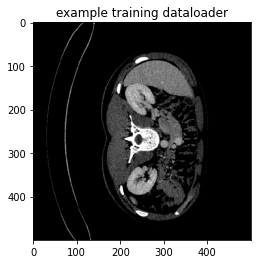

In [ ]:
train_image = class_train_generator[21][0][0]
plt.imshow(train_image)
plt.title('example training dataloader')
plt.show() #TO DO add title to this image

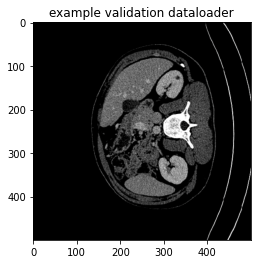

In [ ]:
val_image = class_valid_generator[1][0][0]
plt.imshow(val_image)
plt.title('example validation dataloader')
plt.show() #TO DO add title to this image

In [ ]:
# Taking a pretrained base
from tensorflow.keras.applications import efficientnet

from tensorflow.keras.applications import EfficientNetB0
pretrained_base = EfficientNetB0(weights='imagenet')

pretrained_base.summary()  

# The pretrained database not trainable.
pretrained_base.trainable = False

21848064/21834768 [==============================] - 1s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

In [ ]:
# Attaching head
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing

model = keras.Sequential([
    
    # Base
    pretrained_base,
    
    # Head
    layers.Flatten(name='Flatten'),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(loss = 'binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              metrics= ['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1000)             5330571   
                                                                 
 Flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 500)               500500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.0001,
                              mode='min', 
                              verbose=1, 
                              patience=20,
                              restore_best_weights = True
                             )

checkpointer = ModelCheckpoint(filepath="vgg16_1.h5",
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True
                              )

#don't include reduce_lr at the beginning
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15,
                              min_delta=0.00001,
                              factor=0.2
                             )

callbacks = [checkpointer, earlystopping]

In [ ]:
steps_per_epoch = len(class_train_generator)//class_train_generator.batch_size
validation_steps = len(class_valid_generator)
print(f'steps per epoch: {steps_per_epoch}, validation steps: {validation_steps}')

steps per epoch: 2, validation steps: 3


In [ ]:
history = model.fit(class_train_generator, 
              steps_per_epoch= steps_per_epoch, 
              epochs = 50, 
              validation_data= class_valid_generator, 
              validation_steps= validation_steps,
              callbacks=callbacks)

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5938 
Epoch 1: val_accuracy improved from -inf to 0.97561, saving model to vgg16_1.h5
2/2 [==============================] - 37s 26s/step - loss: 0.6922 - accuracy: 0.5938 - val_loss: 0.6700 - val_accuracy: 0.9756
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.7188
Epoch 2: val_accuracy did not improve from 0.97561
2/2 [==============================] - 25s 19s/step - loss: 0.6802 - accuracy: 0.7188 - val_loss: 0.6402 - val_accuracy: 0.9756
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.6719
Epoch 3: val_accuracy did not improve from 0.97561
2/2 [==============================] - 26s 21s/step - loss: 0.6751 - accuracy: 0.6719 - val_loss: 0.6060 - val_accuracy: 0.9756
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.6250
Epoch 4: val_accuracy did not improve from 0.97561
2/2 [=========

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

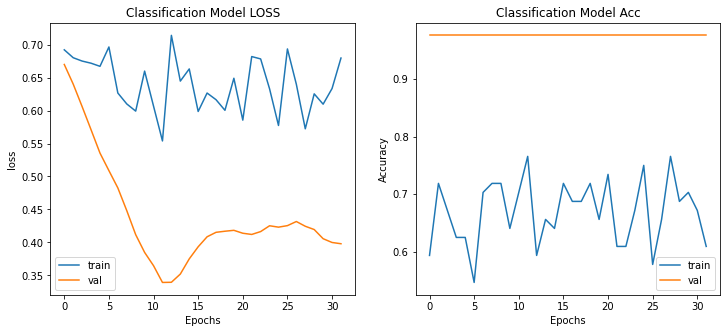

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(class_test_generator)
print("Test accuracy : {} %".format(acc*100))

6/6 [==============================] - 1s 172ms/step - loss: 0.9773 - accuracy: 0.3333
Test accuracy : 33.33333432674408 %


In [ ]:
model.save('/content/modelsave')

INFO:tensorflow:Assets written to: /content/modelsave/assets


In [ ]:
!zip -r /content/gdrive/MyDrive/Donnes_patients/trained_models/classifier2.h5 /content/modelsave